# Classifiers using neuro-imaging data

In [52]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

## Data Pre-Processing

In [53]:

img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [54]:

img_adni2.drop(["LONISID", "IMAGETYPE", "LHIPQC", "RHIPQC", "ST131HS", "ST132HS", "ST133HS", "ST134HS", "ST135HS", "ST136HS", "ST137HS", "ST138HS", "ST139HS", "ST140HS", "ST141HS", "ST142HS", "ST143HS", "ST144HS", "ST145HS", "ST146HS"], inplace=True, axis=1)
img_adni3.drop(["HIPPOQC"], axis=1, inplace=True)

In [55]:
colNames2 = []
for colName2 in img_adni2.columns:
    if not colName2 in img_adni1.columns:
        #print(colName2)
        if not (colName2 == "VISCODE2" or colName2 =="COLPROT"):
            colNames2.append(colName2)

print("---")
for colName3 in img_adni3.columns:
    if not colName3 in img_adni2.columns:
        print(colName3)
print("---")
colNames = []
for colName1 in img_adni1.columns:
    if not colName1 in img_adni2.columns:
        #print(colName1)
        colNames.append(colName1)


img_adni1.drop(colNames, inplace=True, axis=1)
img_adni2.drop(colNames2, inplace=True, axis=1)
img_adni3.drop(colNames2, axis=1, inplace=True)

---
---


In [56]:
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
dx1= dx[(dx["Phase"] == "ADNI1")]
dx2= dx[(dx["Phase"] == "ADNI2") | (dx["Phase"] == "ADNIGO")]
dx3= dx[(dx["Phase"] == "ADNI3")]


In [26]:
img_dx2go.head()

,COLPROT,RID,VISCODE,VISCODE2,EXAMDATE,VERSION,LONIUID,IMAGEUID,RUNDATE,STATUS,...,ST149SV,ST150SV,ST151SV,ST152SV,ST153SV,ST154SV,ST155SV,update_stamp,DXCHANGE,PTID
0,ADNI2,21,v11,m84,2012-10-04,2012-10-24,169744.0,340931,2012-10-24,complete,...,384420.0,196942.0,197448.0,394390.0,142785.0,527205.0,869951.0,2019-11-14 14:34:00.0,1.0,011_S_0021
1,ADNIGO,21,nv,m60,2010-10-08,2012-02-10,93190.0,222684,2012-02-10,complete,...,384534.0,205140.0,204958.0,410098.0,146962.0,531496.0,885815.0,2019-11-14 14:34:00.0,1.0,011_S_0021
2,ADNIGO,21,nv,m60,2010-10-08,2012-02-10,93187.0,222738,2012-02-10,partial,...,375077.0,210619.0,208063.0,418682.0,146446.0,521523.0,883558.0,2019-11-14 14:34:00.0,1.0,011_S_0021
3,ADNI2,21,v06,m72,2011-10-13,2012-04-05,125206.0,265250,2012-04-05,complete,...,366238.0,208414.0,209070.0,417484.0,144658.0,510896.0,877214.0,2019-11-14 14:34:00.0,1.0,011_S_0021
4,ADNI2,21,v21,m96,2013-10-17,2013-12-23,204109.0,398269,2013-12-23,partial,...,373956.0,200248.0,198403.0,398652.0,141727.0,515683.0,860546.0,2019-11-14 14:34:00.0,1.0,011_S_0021


In [57]:
img_dx1 = pd.merge(img_adni1, dx1[["VISCODE", "RID", "DXCURREN", "PTID"]], left_on=["VISCODE","RID"], right_on=["VISCODE","RID"])
img_dx2go = pd.merge(img_adni2, dx2[["VISCODE2", "RID", "DXCHANGE",'PTID']], left_on=["VISCODE2","RID"], right_on=["VISCODE2","RID"])
img_dx3 = pd.merge(img_adni3, dx3[["VISCODE2", "RID", "DIAGNOSIS", "PTID"]], left_on=["VISCODE2","RID"], right_on=["VISCODE2","RID"])

In [58]:
(img_dx1['PTID'].append(img_dx2go['PTID'].append(img_dx3['PTID']))).nunique()

1742

In [62]:
a = img_dx1.append(img_dx2go.append(img_dx3))
a['PTID'].nunique()

1742

In [61]:
img_dx1.rename(columns={"VISCODE": "VISCODE2"})
img_dx2go.drop(["COLPROT"], inplace=True, axis=1)
img_dx3.drop(["COLPROT"], inplace=True, axis=1)

In [99]:
img = img_dx1.append(img_dx2go.append(img_dx3))

In [100]:
img = img.sort_values(['EXAMDATE'])

In [101]:
img = img.drop_duplicates(['PTID'])

In [102]:
len(img)

1742

In [103]:
img[(img["DXCHANGE"] == 1) | (img["DXCHANGE"] == 7) |(img["DXCHANGE"] == 9)] = 1
img[(img["DXCHANGE"] == 2) | (img["DXCHANGE"] == 4) |(img["DXCHANGE"] == 8)] = 2
img[(img["DXCHANGE"] == 3) | (img["DXCHANGE"] == 5) |(img["DXCHANGE"] == 6)] = 3

In [106]:
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCHANGE'])
img['DIAGNOSIS'] = img['DIAGNOSIS'].fillna(img['DXCURREN'])

In [112]:
img.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [115]:
img.columns

'VISCODE'

In [122]:
CVs = []
SVs = []
SAs = []
TSs = []
TAs = []
HSs = []

for col in img.columns:

    if col.endswith('CV'):
        CVs.append(col)
    if col.endswith('SV'):
        SVs.append(col)
    if col.endswith('SA'):
        SAs.append(col)
    if col.endswith('TS'):
        TSs.append(col)
    if col.endswith('TA'):
        TAs.append('col')
    if col.endswith('HS'):
        HSs.append(col)


In [124]:
SVs

['ST101SV',
 'ST112SV',
 'ST11SV',
 'ST120SV',
 'ST124SV',
 'ST125SV',
 'ST127SV',
 'ST128SV',
 'ST12SV',
 'ST16SV',
 'ST17SV',
 'ST18SV',
 'ST1SV',
 'ST21SV',
 'ST29SV',
 'ST2SV',
 'ST30SV',
 'ST37SV',
 'ST3SV',
 'ST42SV',
 'ST4SV',
 'ST53SV',
 'ST5SV',
 'ST61SV',
 'ST65SV',
 'ST66SV',
 'ST68SV',
 'ST69SV',
 'ST6SV',
 'ST70SV',
 'ST71SV',
 'ST75SV',
 'ST76SV',
 'ST77SV',
 'ST7SV',
 'ST80SV',
 'ST88SV',
 'ST89SV',
 'ST8SV',
 'ST96SV',
 'ST9SV',
 'ST147SV',
 'ST148SV',
 'ST149SV',
 'ST150SV',
 'ST151SV',
 'ST152SV',
 'ST153SV',
 'ST154SV',
 'ST155SV']

## Create the classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

### Feature selection

<AxesSubplot:xlabel='DIAGNOSIS', ylabel='Count'>

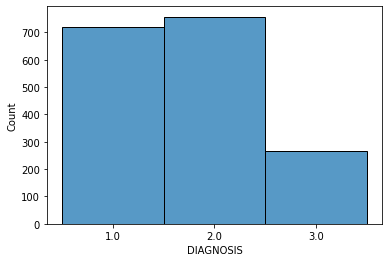

In [127]:
sns.histplot(img['DIAGNOSIS'].astype(str))

In [ ]:
Y = img['Diagnosis']


### Model training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(basic_diagnosis_features, Y, test_size=0.4, train_size=0.6)

### Cross-validation

In [128]:
models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]

### Evaluation

## Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.